# **Titanic colorful EDA 🚢**

### Small colorful EDA kernel to extract knowledge from the data. Feel free to fork this notebook and contribute by adding graphs and analysis !

![](https://i.imgur.com/odF5K21.jpg)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [2]:
# Path of datasets
train_df_raw = pd.read_csv('./datasets/train.csv')
train_df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def preprocess_data(df):
    
    processed_df = df.copy()
    processed_df['Embarked'].fillna('C', inplace=True)
    processed_df['Cabin'].fillna('U', inplace=True)
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in processed_df['Name']), index=processed_df.index)
    processed_df['Title'] = processed_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    processed_df['Title'] = processed_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')
    processed_df['FamillySize'] = processed_df['SibSp'] + processed_df['Parch'] + 1
    processed_df['IsAlone'] = np.where(processed_df['FamillySize']!=1, 0, 1)
    processed_df['IsChild'] = processed_df['Age'] < 18
    processed_df['Deck'] = processed_df['Cabin'].str[:1]
    processed_df['FamillySize'][processed_df['FamillySize'].between(1, 5, inclusive=False)] = 2
    processed_df['FamillySize'][processed_df['FamillySize']>5] = 3
    processed_df['FamillySize'] = processed_df['FamillySize'].map({1: 'Alone', 2: 'Medium Familly', 3: 'Large Familly'})
    processed_df['IsAlone'] = processed_df['IsAlone'].map({0: 'Not Alone', 1: 'Alone'})
    processed_df['Embarked'] = processed_df['Embarked'].map({'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'})
    processed_df['Pclass'] = processed_df['Pclass'].map({1: 'First Class', 2: 'Second Class', 3: 'Third Class'})
    processed_df = processed_df.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], 1)  

    return processed_df

In [4]:
train_df = preprocess_data(train_df_raw)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamillySize,IsAlone,IsChild,Deck
0,0,Third Class,male,22.0,1,0,7.2500,Southampton,Mr,Medium Familly,Not Alone,False,U
1,1,First Class,female,38.0,1,0,71.2833,Cherbourg,Mrs,Medium Familly,Not Alone,False,C
2,1,Third Class,female,26.0,0,0,7.9250,Southampton,Miss,Alone,Alone,False,U
3,1,First Class,female,35.0,1,0,53.1000,Southampton,Mrs,Medium Familly,Not Alone,False,C
4,0,Third Class,male,35.0,0,0,8.0500,Southampton,Mr,Alone,Alone,False,U


## **Distributions of variables**

In [5]:
train_df['Sex'].iplot(kind='hist', 
                      yTitle='Count', 
                      title='Sex Distribution', 
                      colors='#A0DDFF')

In [6]:
train_df[['Embarked', 'Pclass', 'FamillySize' ,'Title']].iplot(kind='hist',
                                                               yTitle='Count', 
                                                               title='Variable Distribution', 
                                                               subplots=True, 
                                                               shape=(2, 2))

In [7]:
train_df_fareoutliers_as_nan = train_df.copy()
train_df_fareoutliers_as_nan[train_df_fareoutliers_as_nan['Fare'] > 100] = np.nan
train_df_fareoutliers_as_nan[['Age', 'Fare']].iplot(kind='hist',
                                                    yTitle='Count', 
                                                    title='Age & Fare Distribution', 
                                                    subplots=True, 
                                                    shape=(2, 1),
                                                    colors=['#7D7ABC', '#00CECB'])

## **Age, Fare & Pclass analysis**

In [8]:
train_df_without_fareoutliers = train_df[train_df['Fare'] < 100]
train_df_without_fareoutliers.pivot(columns='Pclass', values='Fare').iplot(kind='box',
                                                                           title='Age Distribution by Pclass',
                                                                           colors=['#002277', '#51344D', '#F58A07'])

In [9]:
train_df.pivot(columns='Pclass', values='Age').iplot(kind='hist',
                                                     barmode='stack',
                                                     xTitle='Age',
                                                     yTitle='Count',
                                                     title='Age Distribution by Pclass',
                                                     colors=['#5AC7E6', '#FFB045', '#6A6A6A'])

### Logically, first class tickets cost way much than second class tickets. Second class tickets are also a little more expensive than third class but the gap is much smaller. The second graph shows us that there are much more third and second class passenger than first class. Third and second class passenger distributions are guassian (if we excluse childs) whereas first class passenger distribution is more uniform. We can deduce from that that there are much more "senior" people (age > 45 years old) compare to "junior" people (age < 45) in the first class than in the two other classes. In other words, older people are richer !

## **Survivor analysis**

### Let's take a break with interractive plots and come back to our good old seaborn ! So, how many passenger survived ?

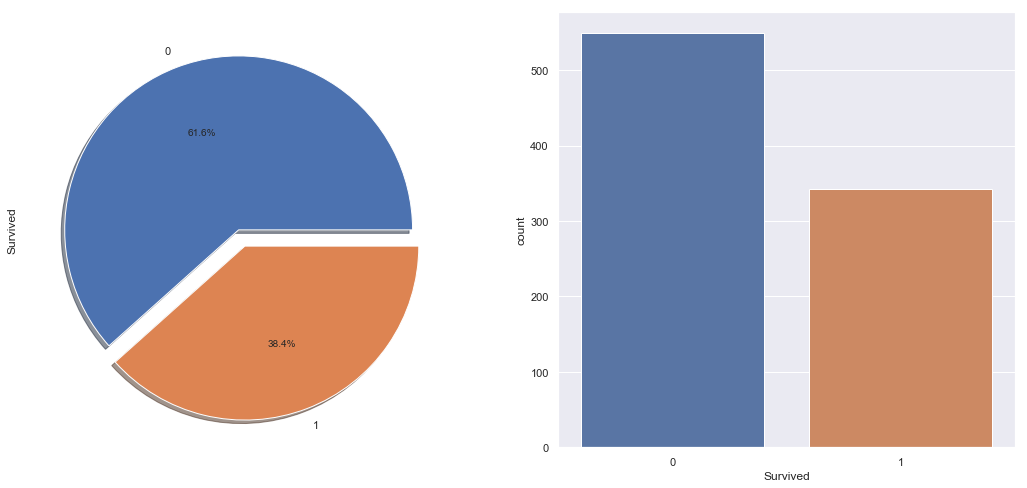

In [10]:
f,axes = plt.subplots(1,2,figsize=(18,8))
train_df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True)
sns.countplot('Survived',data=train_df,ax=axes[1])
plt.show()

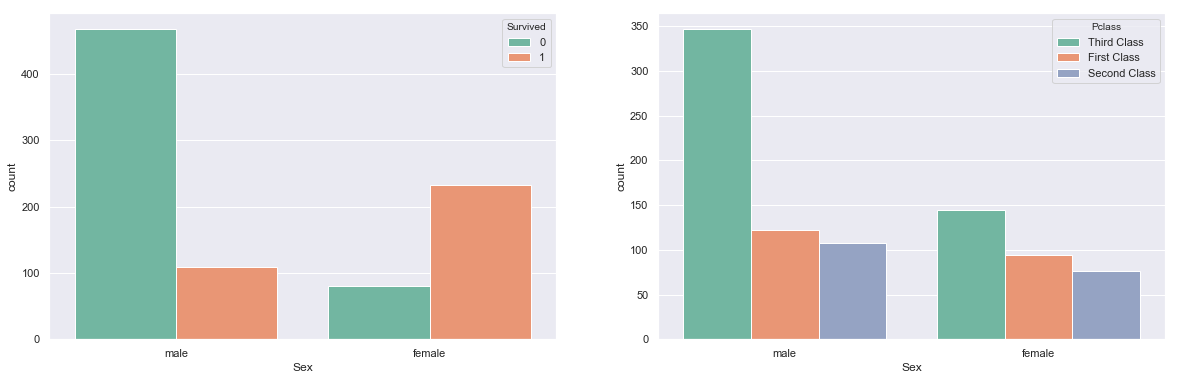

In [11]:
figure, axes = plt.subplots(1,2,figsize=(20,6))
sns.countplot('Sex',hue='Survived',data=train_df, palette=("Set2"), ax=axes[0])
sns.countplot('Sex',hue='Pclass',data=train_df, palette=("Set2"), ax=axes[1])
plt.show()

### There are much more men than mowen on the boat. However we can observe a famale/male parity in the 1st and 2nd class passengers, the imbalance appears only for third class passenger.

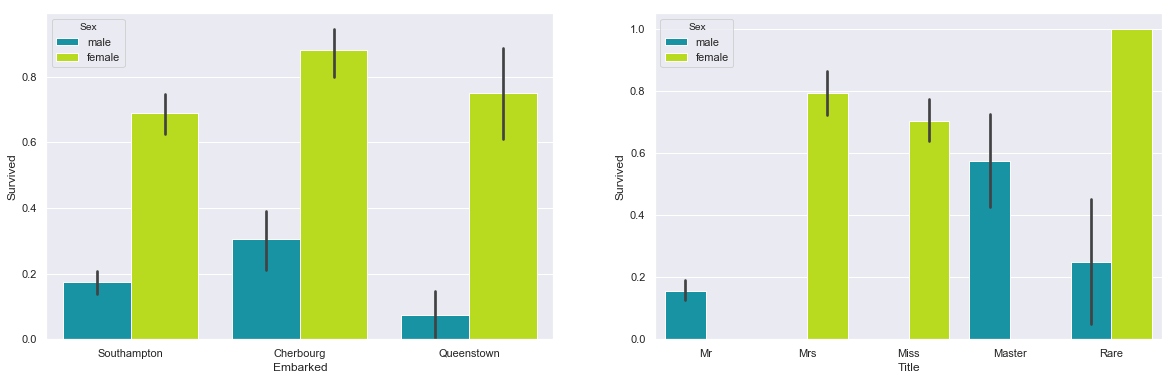

In [12]:
figure, axes = plt.subplots(1,2,figsize=(20,6))
g1 = sns.catplot(x="Embarked", y="Survived", hue="Sex", data=train_df, kind="bar", palette=("nipy_spectral"), ax=axes[0])
g2 = sns.catplot(x="Title", y="Survived", hue="Sex", data=train_df, kind="bar", palette=("nipy_spectral"), ax=axes[1])
plt.close(g1.fig)
plt.close(g2.fig)
plt.show()

### It seems that passengers who comes from Cherbourg are more probable to survived, regardless of sex. Male masters have a very high survival rate, you definitely had to be a master when you were a man to increases your chances to survive.

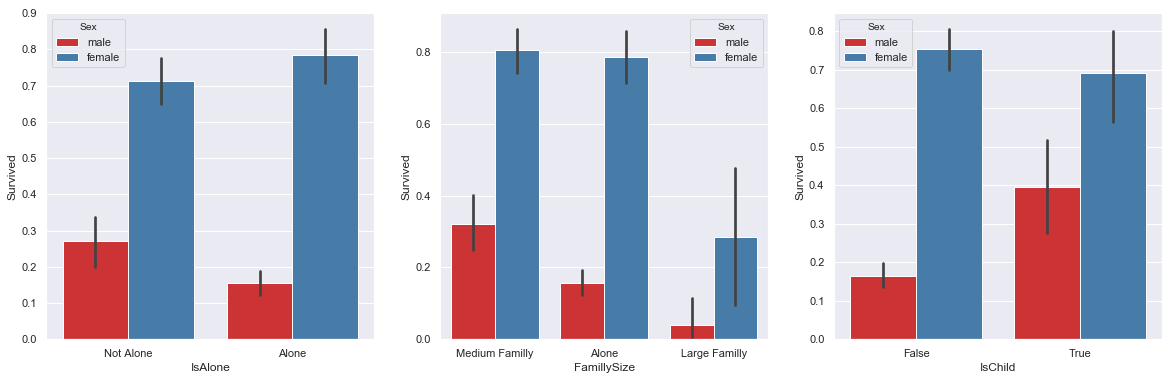

In [13]:
figure, axes = plt.subplots(1,3,figsize=(20, 6))
g1 = sns.catplot(x="IsAlone", y="Survived", hue="Sex", data=train_df, kind="bar", palette=('Set1'), ax=axes[0])
g2 = sns.catplot(x="FamillySize", y="Survived", hue="Sex", data=train_df, kind="bar", palette=('Set1'), ax=axes[1])
g3 = sns.catplot(x="IsChild", y="Survived", hue="Sex", data=train_df, kind="bar", palette=('Set1'), ax=axes[2])
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)
plt.show()

### For men, it's better not to be alone whereas women have higher survival probability by not having family on the boat. Survival probability increases for men when they have a large familly. In general, having too large familly (i.e. > 5 members) reduces the chances of survival. For being a child or not, its the same constat as for being alone : yes for man, no for female.

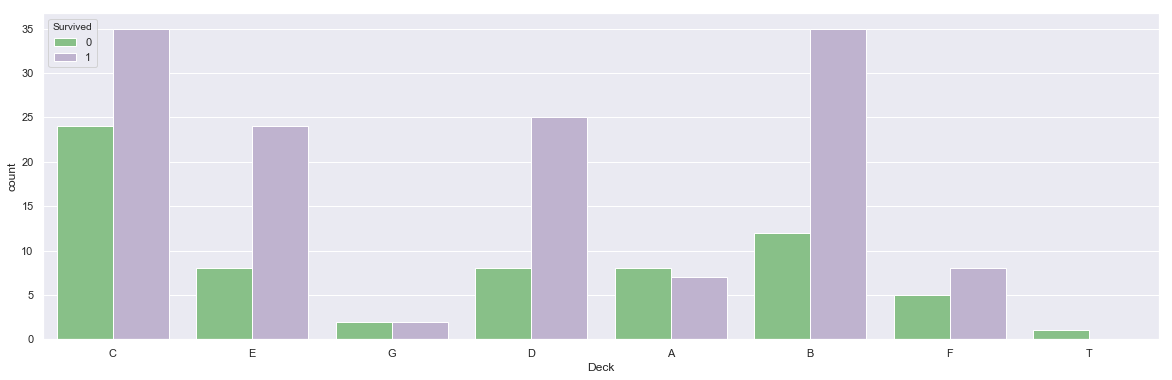

In [14]:
plt.figure(figsize=(20, 6))
train_df_without_u_deck = train_df.drop(train_df[train_df.Deck == 'U'].index)
plot = sns.countplot(x="Deck", hue="Survived", data=train_df_without_u_deck, palette=('Accent'))
plt.show()

### Apparently, decks E, D and B are better than others in terms of survival rates. On the contrary, with near 50% chances to die, decks G, A and F are quite deadly. Let's try to analyse the following titanic deckplan to discover why !

![](https://upload.wikimedia.org/wikipedia/commons/5/5d/Titanic_side_plan_annotated_English.png)

### Interresting ... decks E, D are near lifeboats (on the top of the boat on the above plan), so it is logical that they have an higher surviral rate. I consider also deck B to be near lifeboats because the deck is located at an higher floor than others. Moreover, deck A is very close from where the impact with the iceberg came, so it is logical that passengers in this deck did not have much chance of surviving. But ... wait a minute ! Decks G and F are also near from lifeboats !! Why did passengers in those decks did not survived as well as passengers in decks E, D and B did ? Horrible thought, but can it be because richer passengers had the priority to go on lifeboats ? Let's check if the deck is related to fare or PClass. Do we put rich people on safer places on the Titanic ? [*Suspens*] 😏

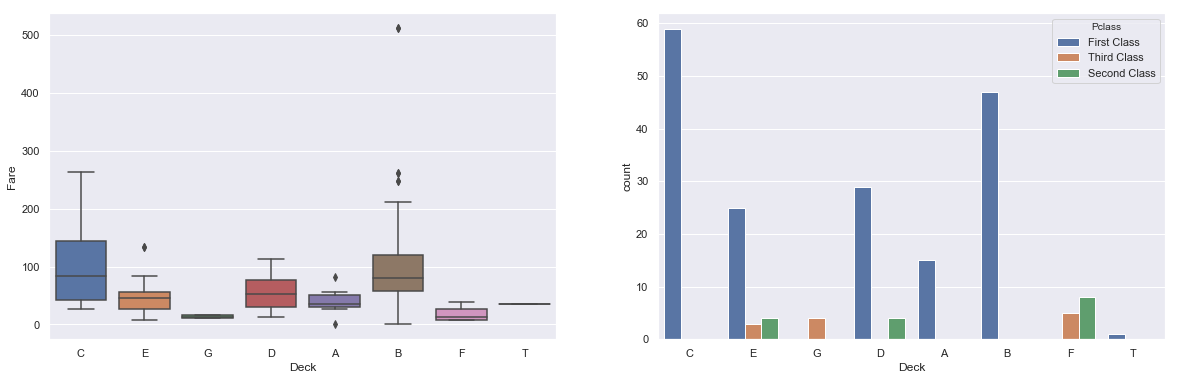

In [15]:
figure, axes = plt.subplots(1,2,figsize=(20,6))
g1 = sns.boxplot(x="Deck", y="Fare", data=train_df_without_u_deck, ax=axes[0])
g2 = sns.countplot(x="Deck", hue="Pclass", data=train_df_without_u_deck, ax=axes[1])
plt.show()

### We can see that deck B is full of 1st class passenger and the mean fare for a cabin in this deck is near 100$, higher than other decks... It may be a coincidence but it is alse the safest decks. And ... wow ! Apparently there is no first class passenger in decks G and F ! This can mean that even if passengers from decks G and F were near from lifeboats, they couldn't access it because first class people from decks B, E and D had the priority !

### Nevertheless, we must relativize! Indeed, we can also see from these two graphs that deck C has also high fare and is full of 1st class passenger but its survival rate is not so good (~60%), although deck C is also near from lifeboats. We can also observe that we have only less than 15 observations for decks G and F, nothing tells us that other passengers from those decks were not first class passengers ! To concluse, it is truly difficult to get some conclusions about decks considering the lack of data for this column.

![](https://i.imgur.com/vVo2ZrH.png)

### We've caught you confirmation bias !

*to be continued ...*